In [6]:
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import norm

In [7]:
m, s = 0, 1
m1, s1, m2, s2 = -2, 0.3, 2, 0.5
p = 0.2

def gaussian_cdf(x, mu, sigma):
    return norm.cdf(x, loc=mu, scale=sigma)    

def gaussian_pdf(x, mu, sigma):
    return 1/(np.abs(sigma) * np.sqrt(2 * np.pi)) * np.exp(-(x-mu)**2/(2 * sigma**2)) #* (np.abs((x-mu)/sigma) < 4)

def mix_cdf(x):
    return p * gaussian_cdf(x, m1, s1) + (1-p) *  gaussian_cdf(x, m2, s2) 

def mix_pdf(x):
    return p * gaussian_pdf(x, m1, s1) + (1-p) *  gaussian_pdf(x, m2, s2) 

def kernel(x, y, u=1):
    return np.exp(- (1/ (2*u)) * np.abs(x-y)**2)

def KG(x, mu, sigma, u=1):
    return np.exp(- (x-mu)**2 / (2 * (u + sigma**2))) / (sigma * np.sqrt(1/u + 1/sigma**2))

def KQ(x, u=1):
    return p * KG(x, m1, s2, u=u) + (1 - p) * KG(x, m2, s2, u=u)

def KS(x, mu, sigma, u=1):
    return 0.5 * ( KG(x, mu, sigma, u=u) + p * KG(x, m1, s2, u=u) + (1 - p) * KG(x, m2, s2, u=u))


In [8]:
def wasserstein(mu, sigma):
    return integrate.quad(lambda x:  np.abs(gaussian_cdf(x, mu, sigma) - mix_cdf(x)), -5, 5)[0]
    
def divergence(mu, sigma, u=1, fwd='fwd'):
    
    if fwd == 'sym':
        rat = lambda x: KG(x, mu, sigma, u=u) / KS(x, mu, sigma, u=u)
        pl = lambda x: gaussian_pdf(x, mu, sigma)
        pr = lambda x: 0.5 * (gaussian_pdf(x, mu, sigma) + mix_pdf(x))
        t1 = integrate.quad(lambda x:  pl(x) * np.log(rat(x)), -5, 5)[0]
        t2 = integrate.quad(lambda x:  pr(x) * rat(x), -5, 5)[0]
         
        rat = lambda x: KQ(x, u=u) / KS(x, mu, sigma, u=u)
        pl = lambda x: mix_pdf(x)
        pr = lambda x: 0.5 * (gaussian_pdf(x, mu, sigma) + mix_pdf(x))
        v1 = integrate.quad(lambda x:  pl(x) * np.log(rat(x)), -5, 5)[0]
        v2 = integrate.quad(lambda x:  pr(x) * rat(x), -5, 5)[0]
        
        return 0.5 * ( 1 + t1 - t2 + 1 + v1 - v2)
    
    elif fwd == 'fwd':
        rat = lambda x: KG(x, mu, sigma, u=u) / KQ(x, u=u)
        pl = lambda x: gaussian_pdf(x, mu, sigma)
        pr = lambda x: mix_pdf(x)
    elif fwd == 'bwd':
        rat = lambda x: KQ(x, u=u) / KG(x, mu, sigma, u=u) 
        pl = lambda x: mix_pdf(x)
        pr = lambda x: gaussian_pdf(x, mu, sigma)    
        
    t1 = integrate.quad(lambda x:  pl(x) * np.log(rat(x)), -5, 5)[0]
    t2 = integrate.quad(lambda x:  pr(x) * rat(x), -5, 5)[0]
 
    return 1 + t1 - t2

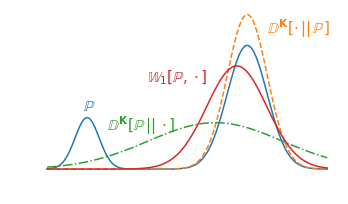

In [16]:
u = 0.1

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 12


plt.figure(figsize=(5, 3))

x = np.linspace(-3, 4, 100)
plt.plot(x, mix_pdf(x), markersize=2, label='True')

f = lambda w: divergence(w[0], w[1], u=u, fwd='fwd')
res2 = minimize(f, x0=[1, 0.1], method='Nelder-Mead', tol=1e-6)
plt.plot(x, gaussian_pdf(x, res2.x[0], res2.x[1]), '--',  markersize=2, label='D(Data, Model)')

f = lambda w: divergence(w[0], w[1], u=u, fwd='bwd')
res1 = minimize(f, x0=[0, 2], method='Nelder-Mead', tol=1e-6)
plt.plot(x, gaussian_pdf(x, res1.x[0], res1.x[1]), '-.',  markersize=2, label='D(Model, Data)')

#f = lambda w: wasserstein(w[0], w[1])
#res = minimize(f, x0=[1, 0.1], method='Nelder-Mead', tol=1e-6)
plt.plot(x, gaussian_pdf(x, res.x[0], res.x[1]), '-',  markersize=2, label='W(True, Mod)')


plt.axis('off')

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.text(-2.1, 0.3, r'$\mathbb{P}$', fontsize=15, color='#1f77b4')
plt.text(2.5, 0.7, r'$\mathbb{D}^{\mathbf{K}}[\cdot \, || \, \mathbb{P}]$',fontsize=15, color='#ff7f0e')
plt.text(-1.5, 0.2, r'$\mathbb{D}^{\mathbf{K}}[\mathbb{P} \, || \, \cdot]$', fontsize=15, color='#2ca02c')
plt.text(-0.5, 0.45, r'$\mathbb{W}_1[\mathbb{P}, \cdot]$', fontsize=15, color='#d62728')

plt.tight_layout()
plt.savefig('mog_divergence', dpi=400)

# f = lambda w: divergence(w[0], w[1], u=u, fwd='sym')
# res = minimize(f, x0=[2, 1], method='Nelder-Mead', tol=1e-6)
# print(res.x)
# plt.plot(x, gaussian_pdf(x, res.x[0], res.x[1]), label='JS(True, Mod)')

#plt.legend()
#plt.plot(x, kernel(x, 0, u=0.1))

In [32]:
gs = 20
mus = np.linspace(-1, 2, gs)
sigmas = np.linspace(0.1, 2, gs)

M, S = np.meshgrid(mus, sigmas)

Z = np.zeros((gs, gs))
for i in range(gs):
    for j in range(gs):
        Z[i, j] = divergence(M[i, j], S[i,j])

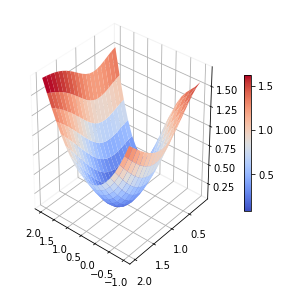

In [44]:
fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')
ax.view_init(30, 130)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
surf = ax.plot_surface(M, S, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=20)
plt.show()